Необходимые импорты

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import math

import json

from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from sklearn.model_selection import train_test_split

import random

Импорт класса для обработки текста

In [2]:
from text_preproccessor import TextPreproccessor

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SsaWin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Гиперпараметры

In [3]:
vocab_size = 4000
embedding_dim = 128
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<word>'
test_size = 0.2
num_epochs = 20

Получение данных из файла

In [4]:
def get_texts_from_excel_file(file_path: str) -> pd.DataFrame:
    return pd.read_excel(file_path).dropna()

In [5]:
TEXTS_FILEPATH = 'texts.xlsx'

In [6]:
texts_df = get_texts_from_excel_file(TEXTS_FILEPATH)

Преобразование текста для обучения

In [63]:
class_counts = texts_df['name'].value_counts()

#Считаем встречаемость классов в датасете
name2count = {name:count for name,count in zip(class_counts.index, class_counts.values)}

# Добавляем в таблицу столбец вхождений класса
texts_df['class_count'] = texts_df['name'].apply(lambda x: name2count[x])

#Оставляем только те строки, классы которых встречаются более одного раза
data = texts_df[texts_df['class_count'] > 1][['description', 'name']]

# Составляем словарь для категорий
name2class_id = {name: idx for idx, name in enumerate(data['name'].unique())}

# Добавляем в таблицу столбец с индексами классов
data['class_id'] = data['name'].apply(lambda x: name2class_id[x])

# Удаляем столбец с названиями категорий
data.drop(['name'], axis=1, inplace=True)

text_preproccessor = TextPreproccessor()

# Обработка текста для обучения
tqdm.pandas()
data['description'] = data['description'].progress_apply(lambda x: text_preproccessor.preproccess_text(x))


100%|██████████| 9431/9431 [2:19:20<00:00,  1.13it/s]  


In [66]:
data.to_excel('prepared_data.xlsx', index=False)

In [5]:

with open('category_vocab.json', 'r') as json_file:
    name2class_id = json.load(json_file)

In [6]:
data = get_texts_from_excel_file('prepared_data.xlsx')


Формирование обучающей и проверяющей выборки

In [7]:
X = data['description'].values
y = data['class_id'].values
#Делим датасет на тренировочную и тестовую выборки, учитывая распределение классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

In [8]:
description_tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
description_tokenizer.fit_on_texts(X_train)
description_word_index = description_tokenizer.word_index
dict(list(description_word_index.items())[0:5])

{'<word>': 1, 'дом': 2, 'необходимо': 3, 'улица': 4, 'рядом': 5}

In [9]:
train_sequences = description_tokenizer.texts_to_sequences(X_train)
print(train_sequences[:2])

[[86, 27, 784, 41, 168, 834, 1, 1, 2435, 62, 1, 375, 1, 21, 1, 289, 1, 1, 125, 2063, 85, 135, 1144], [3, 7, 6, 207, 8, 5, 2, 4, 144]]


In [10]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
validation_sequences = description_tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [12]:
size_of_label = len(name2class_id)
size_of_label

127

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(size_of_label, activation='softmax')
])
model.summary()


ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)

In [51]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_test), verbose=2)

Epoch 1/20
25/25 - 8s - loss: 3.6528 - accuracy: 0.4437 - val_loss: 2.7100 - val_accuracy: 0.5050 - 8s/epoch - 334ms/step
Epoch 2/20
25/25 - 5s - loss: 2.4235 - accuracy: 0.4950 - val_loss: 2.3057 - val_accuracy: 0.5150 - 5s/epoch - 202ms/step
Epoch 3/20
25/25 - 5s - loss: 2.1868 - accuracy: 0.5150 - val_loss: 2.2584 - val_accuracy: 0.5150 - 5s/epoch - 199ms/step
Epoch 4/20
25/25 - 5s - loss: 2.0432 - accuracy: 0.5275 - val_loss: 2.2702 - val_accuracy: 0.5100 - 5s/epoch - 207ms/step
Epoch 5/20
25/25 - 5s - loss: 1.9231 - accuracy: 0.5375 - val_loss: 2.3184 - val_accuracy: 0.5100 - 5s/epoch - 206ms/step
Epoch 6/20
25/25 - 5s - loss: 1.8538 - accuracy: 0.5350 - val_loss: 2.3917 - val_accuracy: 0.5100 - 5s/epoch - 200ms/step
Epoch 7/20
25/25 - 5s - loss: 1.7702 - accuracy: 0.5537 - val_loss: 2.4195 - val_accuracy: 0.5150 - 5s/epoch - 202ms/step
Epoch 8/20
25/25 - 5s - loss: 1.6909 - accuracy: 0.5625 - val_loss: 2.5574 - val_accuracy: 0.5200 - 5s/epoch - 200ms/step
Epoch 9/20
25/25 - 5s - 

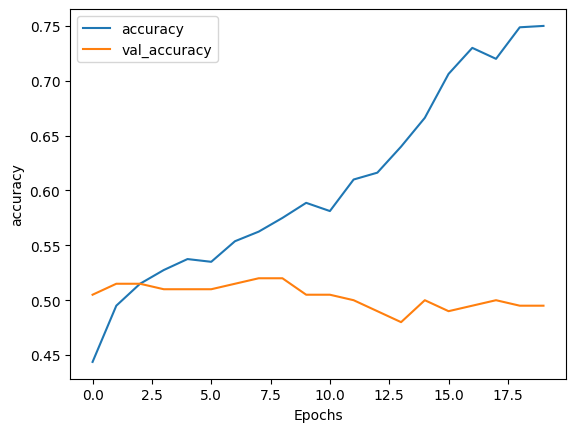

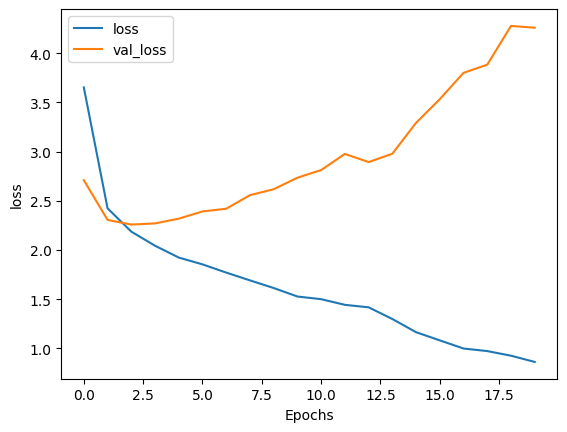

In [53]:
def plot_graphs(history, string):
 plt.plot(history.history[string])
 plt.plot(history.history['val_'+string])
 plt.xlabel("Epochs")
 plt.ylabel(string)
 plt.legend([string, 'val_'+string])
 plt.show()


plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
